# vorher nochmal 3a_feature_engineerung_zyklus.ipynb laufen lassen

# Imports

In [1]:
import sys
import os

parentdir = os.path.dirname(os.path.abspath(''))
sys.path.append(parentdir)

from datetime import date

import pandas as pd
import numpy as np

import pandas_profiling as pd_profil

import functions as fu
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


%matplotlib inline

# Pfade setzen
c_fold = fu.get_folder()
p_fold = c_fold + '\data\Prepared'
folder = c_fold + '\data\Processed\Zyklus'
folder_final = c_fold + '\data\Processed\\final'

# y = df.loc[:, df.columns.isin(['amperestunden'])]
# X = df.loc[:, ~df.columns.isin(['amperestunden'])]

# Daten vorbereiten

In [2]:
daten = pd.read_csv(f"{folder_final}\\df_fertige_features_ref_discharge.csv", sep=',')
daten.drop(["batteryname_","comment_","type_"], axis=1, inplace=True) #brauch ich hier nicht
daten.drop(["time_amin"], axis=1, inplace=True) #zu viel überschneidung mit *_leicht_vorher
daten = daten[daten["amperestunden"] != 0] #nicht logisch


#Ausreißer raus
daten_ohne_aus = daten.copy()
spalten_mit_ausreißern = ["temperature_amax","temperature_amin",'temperature_mean']
for spalte in spalten_mit_ausreißern:
    neuer_wert = daten_ohne_aus[daten_ohne_aus[spalte] > np.percentile(daten_ohne_aus[spalte],10)][spalte].median() #ersetzen durch den Median der Restwerte
    daten_ohne_aus.loc[daten_ohne_aus[spalte] < np.percentile(daten_ohne_aus[spalte],10),spalte] = neuer_wert #neuen Wert setzen

    
# train test split
train_set, test_set = train_test_split(daten_ohne_aus, test_size=0.2, random_state=42)

daten = train_set.drop("amperestunden", axis=1)
daten_labels = train_set["amperestunden"].copy()


test_daten = train_set.drop("amperestunden", axis=1)
test_daten_labels = train_set["amperestunden"].copy()

# Pipeline mit Regressor und Metriken

RMSE: 0.017313937671897334
R2: 0.9971082880610206


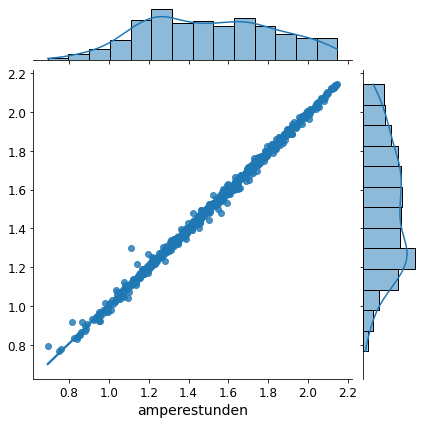

In [3]:
import joblib
prepare_and_predict_pipeline_load = joblib.load("pickle/prepare_and_predict_pipeline.pkl")

test_daten_pred = prepare_and_predict_pipeline_load.predict(test_daten)
test_daten_pred_series = pd.Series(test_daten_pred, index=test_daten_labels.index)

sns.jointplot(x=test_daten_labels,y=test_daten_pred_series, kind='reg')

from sklearn import metrics
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_daten_labels, test_daten_pred_series)))
print('R2:',metrics.r2_score(test_daten_labels, test_daten_pred_series))

## noch drei andere Kleine Sachen
#### Seite 4
* auf Seite 4 von der App Ist nur das Histogramm mit Ausreißern - kann man da vllt beide hinmachen? Die Bilder davon liegen schon unter notebooks/images

#### Seite 5
* wenn man es hinkriegt "das beste Modell" reinzukriegen, wäre es vllt cool ein zwei Hyperparameter davon darzustellen
    * 'n_estimators': 452, 'max_depth': 115
   
   
   

* für das lineare Modell am besten auch die Daten (heißt auch Variable daten) nehmen die hier in "Daten vorbereiten" sind und auch auf die wichtigen Features filtern (wie am Ende bei 6_feature:imp) . Da hab ich noch ein paar Spalten rausgeschmissen und Ausreißer entfernt. Am ende habe ich dann nur die wichtigen Spalten genommen